# Queensland State Archives, Naturalisations, 1851 to 1904

## Add series information to index

The [Naturalisations, 1851 to 1904](https://data.qld.gov.au/dataset/naturalisations-1851-to-1904) index is available from the Queensland Government data portal. The notes explain:

> This index was created from various records detailing the names of those who took oaths of allegiance to be naturalised as created by the Supreme Court across Queensland as well as the Colonial Secretary's Office and the Government Residents Office.

It's not clear, however, that this means that the index collates name entries from a number of different series, with a separate row for each name reference. This means that there can be multiple rows referring to the naturalisation of a single individual. This is obviously important to keep in mind if you're trying to analyse aggregate data relating to naturalisations in Queensland.

This notebook adds series information to the original index so that you can filter the data by series.

In [1]:
import pandas as pd
import altair as alt
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook
from tqdm.auto import tqdm
from IPython.display import display, HTML, FileLink
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

### Load the data

In [2]:
# The encoding option is necessary to avoid unicode errors
df = pd.read_csv('https://data.qld.gov.au/dataset/91970fa7-d3c3-4171-a89d-410481cb90e9/resource/7b5ddae5-78ef-4d8e-b800-56e6f30d26d5/download/naturalisations-1851-1908.csv', encoding='ISO-8859-1', keep_default_na=False)

In [3]:
df.head()

,Last name,Given names,Number,Page,Year,Item ID,QSA ref,Microfilm no,Notes,Index name,Description,Source
0,AANENSEN,Gunder,20,,1901,1697781,A/49120,Z1999,,Naturalisations 1851-1908,Generated from records created by the Supreme ...,http://www.archivessearch.qld.gov.au/Search/It...
1,AAROE,Knud Lauritzen,7532,,1885,882267,SCT/CF16,Z2206,,Naturalisations 1851-1908,Generated from records created by the Supreme ...,http://www.archivessearch.qld.gov.au/Search/It...
2,AAROE,Knud Lauritzen,7532,42,1885,841183,SCT/CF37,Z2286,,Naturalisations 1851-1908,Generated from records created by the Supreme ...,http://www.archivessearch.qld.gov.au/Search/It...
3,AASKOO,Hans Pedersen,4050,A,1877,841182,SCT/CF36,Z2286,,Naturalisations 1851-1908,Generated from records created by the Supreme ...,http://www.archivessearch.qld.gov.au/Search/It...
4,AASKOO,Hans Pedersen,4050,B,1877,841182,SCT/CF36,Z2286,,Naturalisations 1851-1908,Generated from records created by the Supreme ...,http://www.archivessearch.qld.gov.au/Search/It...


In [4]:
# How many rows?
len(df)

26769

### Add series information

One way of removing duplicates is to filter the results by series. However, while each entry includes an `Item ID`, it doesn't include a series identifier. To get the series information we have to request the item details web page, and scrape the series information from it.

Rather than loop through the whole dataset, we'll grab all the unique `ItemID` values first, get the series information for each, then merge this data back into the original dataset.

In [5]:
def get_series(row):
    '''
    Get the series id and title for the item identifier in the given row.
    '''
    response = requests.get('http://www.archivessearch.qld.gov.au/Search/ItemDetails.aspx', params={'ItemId': row['item_id']})
    soup = BeautifulSoup(response.text)
    series_id = soup.find(id='ctl00_cphMain_RecordDetailsView_SeriesFormView_SERIES_IDLabel').string
    series_title = soup.find('a', id='ctl00_cphMain_RecordDetailsView_SeriesFormView_TitleHyperLink').string
    return pd.Series([series_id, series_title])

tqdm.pandas(desc="Progress")
# Get the unique item ids
item_ids = pd.DataFrame(df['Item ID'].unique())
item_ids.columns = ['item_id']
# Get series data for each item id
item_ids[['series_id', 'series_title']] = item_ids.progress_apply(get_series, axis=1)

Now we have a dataframe linking item ids to series information, we can find out something about the series represented in the original dataset.

In [6]:
pd.set_option('display.max_colwidth', -1)
# List the indexed series
item_ids[['series_id', 'series_title']].drop_duplicates()

,series_id,series_title
0,9403,Naturalisation Files
1,5741,Oaths of Allegiance Sworn by Aliens Being Naturalised
2,5177,Registers of Aliens to Whom Oaths of Allegiance for Naturalisation Were Administered
5,8400,Special Batches
6,7224,Oaths of Allegiance
29,5743,Certificates of Naturalisation and Associated Papers
43,7164,Register of Fees of Office
50,12748,"Letters Addressed to the Government Resident by the Colonial Secretary, Sydney"
54,5745,"Applications for Copies of Records of Naturalisation, and Related Correspondence"
67,5253,Inwards Correspondence


Merge the series data back into the original dataset.

In [7]:
pd.set_option('display.max_colwidth', 50)
# Merge the series data into the original dataset
qld_df = pd.merge(df, item_ids, left_on='Item ID', right_on='item_id', how='left')
qld_df.head()

,Last name,Given names,Number,Page,Year,Item ID,QSA ref,Microfilm no,Notes,Index name,Description,Source,item_id,series_id,series_title
0,AANENSEN,Gunder,20,,1901,1697781,A/49120,Z1999,,Naturalisations 1851-1908,Generated from records created by the Supreme ...,http://www.archivessearch.qld.gov.au/Search/It...,1697781,9403,Naturalisation Files
1,AAROE,Knud Lauritzen,7532,,1885,882267,SCT/CF16,Z2206,,Naturalisations 1851-1908,Generated from records created by the Supreme ...,http://www.archivessearch.qld.gov.au/Search/It...,882267,5741,Oaths of Allegiance Sworn by Aliens Being Natu...
2,AAROE,Knud Lauritzen,7532,42,1885,841183,SCT/CF37,Z2286,,Naturalisations 1851-1908,Generated from records created by the Supreme ...,http://www.archivessearch.qld.gov.au/Search/It...,841183,5177,Registers of Aliens to Whom Oaths of Allegianc...
3,AASKOO,Hans Pedersen,4050,A,1877,841182,SCT/CF36,Z2286,,Naturalisations 1851-1908,Generated from records created by the Supreme ...,http://www.archivessearch.qld.gov.au/Search/It...,841182,5177,Registers of Aliens to Whom Oaths of Allegianc...
4,AASKOO,Hans Pedersen,4050,B,1877,841182,SCT/CF36,Z2286,,Naturalisations 1851-1908,Generated from records created by the Supreme ...,http://www.archivessearch.qld.gov.au/Search/It...,841182,5177,Registers of Aliens to Whom Oaths of Allegianc...


### Save as CSV

Save the enriched dataset as a CSV file.

In [8]:
qld_df.to_csv('qsa_naturalisations_index_with_series.csv', index=False)
display(FileLink('qsa_naturalisations_index_with_series.csv'))

/Users/tim/mycode/glam-workbench/qsa/notebooks/qsa_naturalisations_index_with_series.csv

### Explore by series

Now that we've associated each entry in the original dataset with a series, we can break the data down by series to better understand the content of the index.

In [9]:
# Number of entries per series
qld_df['series_id'].value_counts()

5177     14325
5741     10344
7224       734
8400       528
9403       258
5743       230
5745       131
7164       122
5253        82
12748       15
Name: series_id, dtype: int64

In [10]:
def filter_by_series(series_id):
    '''
    Filter datatset by series id.
    '''
    filtered_df = qld_df.loc[qld_df['series_id'] == series_id].copy()
    return filtered_df

def get_counts_by_year(df):
    '''
    Aggregate data by year and prepare for charting.
    '''
    counts = df['Year'].groupby([df['Year']]).agg('count').to_frame()
    counts.columns = ['count']
    counts = counts.reset_index()
    # Filter out date errors
    counts = counts.loc[(counts['Year'] > 0) & (counts['Year'] < 1910)].copy()
    # Create a datetime field
    counts['date'] = pd.to_datetime(counts['Year'], format='%Y')
    return counts

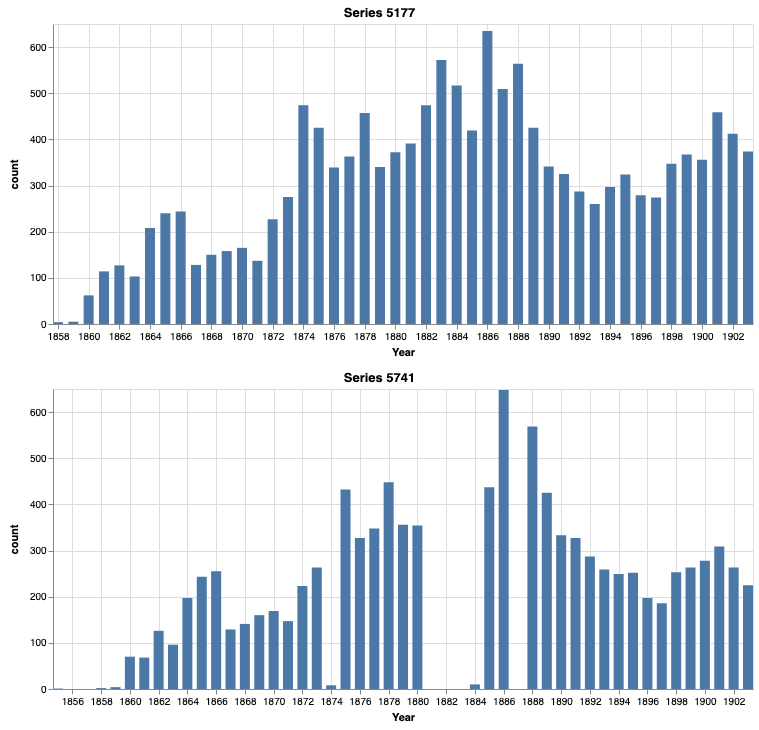

In [11]:
df_5177 = filter_by_series('5177')
df_5741 = filter_by_series('5741')

c1 = alt.Chart(get_counts_by_year(df_5177)).mark_bar(size=10).encode(
    x=alt.X('year(date):T', title='Year'),
    y='count:Q'
).properties(
    width=700,
    title='Series 5177'
)

c2 = alt.Chart(get_counts_by_year(df_5741)).mark_bar(size=10).encode(
    x=alt.X('year(date):T', title='Year'),
    y='count:Q'
).properties(
    width=700,
    title='Series 5741'
)

c1 & c2